# Train Torch Models

Trains a LSTM and a Transformer on the sentiment dataset

In [1]:
# To allow importing modules from src
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import re
import datetime
import itertools

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import tensorboard as tb
# Run tensorboard --logdir=runs in terminal, open http://localhost:6006 to view tb
from torch.nn.utils import clip_grad_norm_
from torchtext.vocab import build_vocab_from_iterator

from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
from lr_finder import LRFinder
from helpers import (SentimentDataset, save_model, load_model,
                     SENTIMENT_TO_ID, ID_TO_SENTIMENT, test_accuracy)

In [3]:
BATCH_SIZE = 100
MAX_LEN = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")

In [4]:
train_set = SentimentDataset('../../data/fixed-data/sentiment-train.csv')
test_set = SentimentDataset('../../data/fixed-data/sentiment-val.csv')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

### Data Pre-processing

In [5]:
def tokenize(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    tokens = word_tokenize(sentence)
    return [token.lower().strip() for token in tokens if token.isalpha()]


def tokenize_batch(data):
    # Converts words to tokens
    for sentences, _ in data:
        for sentence in sentences:
            yield tokenize(sentence)

def build_vocab(data):
    vocab = build_vocab_from_iterator(tokenize_batch(data), specials=['<pad>','<unk>'], min_freq=10)
    # Set words outside the vocabulary to <unk>
    vocab.set_default_index(vocab["<unk>"])
    return vocab

vocab = build_vocab(train_loader)
print(vocab.get_itos()[:10])
print(len(vocab))
vocab(['here', 'is', 'an', 'example',"Let's", 'go', 'U.S.'])

['<pad>', '<unk>', 'to', 'in', 'the', 'for', 'on', 'of', 'analyst', 'stocks']
14443


[1283, 18, 179, 9472, 1, 370, 1]

In [6]:
def feature_pipeline(sentence, vocab, max_length=25):
    """Converts a sentence to a tensor of token indices, pads it to a fixed length, 
    and converts it to a one-hot vector.
    """
    tokens = tokenize(sentence)
    if len(tokens) < max_length:
        pad_size = max_length - len(tokens)
        tokens = ['<pad>'] * pad_size + tokens
    else:
        tokens = tokens[:max_length]
    tokens = vocab(tokens)
    tokens = torch.tensor(tokens, dtype=torch.int64)
    return tokens


feature_pipeline('Here is an example, Let\'s go U.S.!', vocab)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1283,   18,  179, 9472, 2939,  370,
          12])

In [7]:
def label_pipeline(labels):
    return torch.nn.functional.one_hot(labels, num_classes=3)

print(SENTIMENT_TO_ID)
label_pipeline(torch.tensor([0, 1, 2]))

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [8]:
def collate_batch(batch, vocab, max_length):
    """Process a batch of data to its proper form."""
    # Feature should be batch_size * num_words * num_vocabs
    features, labels = zip(*batch)
    features = [feature_pipeline(feature, vocab, max_length) for feature in features]
    onehot_labels = [label_pipeline(label) for label in labels]
    features = torch.stack(features, dim=0)
    labels = torch.stack(onehot_labels)
    return features, labels


train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=lambda x: collate_batch(x, vocab, max_length=MAX_LEN))
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, 
                         collate_fn=lambda x: collate_batch(x, vocab, max_length=MAX_LEN))

### Training Helper Functions

In [10]:
def train_model(
    model, criterion, optimizer, train_loader, test_loader, writer,
    num_epochs, scheduler=None, device='cuda', max_norm=None
):
    test_iter = itertools.cycle(iter(test_loader))
    num_batches = len(train_loader)
    writer.add_text('Hyperparameters', f'num_epochs: {num_epochs}, num_batches: {num_batches}')

    progress_bar = tqdm(range(num_epochs*num_batches))
    epoch_bar = tqdm(range(num_epochs))
    for epoch in range(0, num_epochs):
        batch_idx = 0
        for train_batch in train_loader:
            train_loss, train_accuracy = _train_one_round(train_batch, model, criterion, optimizer, 
                                                          device, max_norm)            
            if batch_idx % 10 == 0:
                test_batch = next(test_iter)
                test_loss, test_accuracy = _evaluate_one_round(test_batch, model, criterion, device)
                gradient_norm = _get_gradient_norm(model)
            
                n_iter = batch_idx + num_batches * epoch
                _write_to_tboard(writer, n_iter, train_loss, test_loss, 
                                 train_accuracy, test_accuracy, gradient_norm)
            batch_idx += 1
            progress_bar.update(1)
        epoch_bar.update(1)
        if scheduler:
            scheduler.step()


def _train_one_round(batch, model, criterion, optimizer, device='cuda', max_norm=None):
    optimizer.zero_grad()
    features, targets = batch
    features = features.to(device=device)
    targets = targets.to(device=device)

    output = model(features)
    if isinstance(output, tuple):
        output = output[0]
    loss = criterion(output.float(), targets.float())
    loss.backward()
    if max_norm:
        clip_grad_norm_(model.parameters(), max_norm=max_norm)  # Prevents exploding gradients
    optimizer.step()

    accuracy = (output.argmax(dim=1) == targets.argmax(dim=1)).sum().item() / len(targets)
    del features, targets, output
    return loss, accuracy


def _get_gradient_norm(model):
    """Computes the gradient norm of a model. I.e. the sum of the size of all gradients"""
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm


def _evaluate_one_round(batch, model, criterion, device='cuda'):
    features, targets = batch
    features = features.to(device=device)
    targets = targets.to(device=device)

    with torch.no_grad():
        output = model(features)
        if isinstance(output, tuple):
            output = output[0]
        loss = criterion(output.float(), targets.float())

    accuracy = (output.argmax(1) == targets.argmax(1)).sum().item() / len(targets)
    del features, targets, output
    return loss, accuracy


def _write_to_tboard(writer, n_iter, train_loss, test_loss, 
                     train_accuracy, test_accuracy, gradient_norm):
    writer.add_scalar('Train loss', train_loss, n_iter)
    writer.add_scalar('Test loss', test_loss, n_iter)
    writer.add_scalar('Train accuracy', train_accuracy, n_iter)
    writer.add_scalar('Test accuracy', test_accuracy, n_iter)
    writer.add_scalar('Gradient norm', gradient_norm, n_iter)

### Train LSTM

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_lstm_layers=2, gain=1.0):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc3 = nn.Linear(hidden_size//4, hidden_size//8)
        self.fc4 = nn.Linear(hidden_size//8, hidden_size//16)
        self.fc5 = nn.Linear(hidden_size//16, output_size)
        
        # Initialize the LSTM weights using Xavier normal initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param.data, gain=gain)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        output = self.dropout(output[:, -1, :])
        output = torch.relu_(self.fc1(output))
        output = torch.relu_(self.fc2(output))
        output = torch.relu_(self.fc3(output))
        output = torch.relu_(self.fc4(output))
        output = self.fc5(output)
        return output.float(), (h_n, c_n)

In [12]:
vocab_size = len(vocab)
HIDDEN_SIZE = 200
NUM_OUTPUTS = 3
NUM_LSTM_LAYERS = 2

model = LSTMModel(len(vocab), BATCH_SIZE, HIDDEN_SIZE, NUM_OUTPUTS, 
                  num_lstm_layers=NUM_LSTM_LAYERS, gain=3).to(device)
criterion = nn.CrossEntropyLoss()

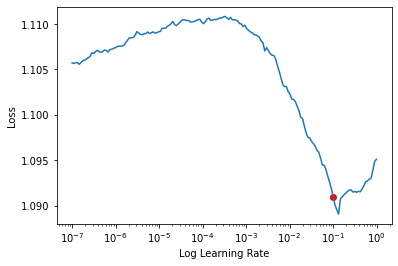

0.10044754989265563

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lrfinder = LRFinder(model, optimizer, criterion, device=device)
lrfinder.run(train_loader, init_value=1e-7, final_value=1, beta=0.01)
best_lr = lrfinder.plot()
lrfinder.reset()
best_lr

In [ ]:
NUM_EPOCHS = 5
# update the optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=5e-3)
# Create a lr scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
writer = tb.SummaryWriter(f"../../runs/lstm {now}")
train_model(model, criterion, optimizer, writer=writer, scheduler=scheduler,
            train_loader=train_loader, test_loader=test_loader, 
            num_epochs=NUM_EPOCHS, max_norm=1, device=device)

### Evaluate LSTM

In [13]:
test_accuracy(model, test_loader, device)

Test size: 9353
Baseline accuracy: 39.39 %
Accuracy: 79.65 %


In [14]:
# save model state
save_model(model, f'../../models/lstm {now}.pth')

In [16]:
# load model state
model2 = LSTMModel(len(vocab), BATCH_SIZE, HIDDEN_SIZE, NUM_OUTPUTS, 
                   num_lstm_layers=NUM_LSTM_LAYERS, gain=3)
load_model(model2, f'../../models/lstm {now}.pth', device)

test_accuracy(model2, test_loader, device)
del model2

Test size: 9353
Baseline accuracy: 39.39 %
Accuracy: 79.65 %


### Train Transformer

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, hidden_size2, hidden_size3, output_size):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoder = PositionalEncoding(embedding_size)
        encoder_layer = nn.TransformerEncoderLayer(embedding_size, nhead=4, dim_feedforward=hidden_size)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(hidden_size, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)
        self.fc3 = nn.Linear(hidden_size3, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.pos_encoder(embedded)
        encoded = self.encoder(embedded)
        pooled = self.pooling(encoded.permute(0, 2, 1)).squeeze(-1)
        fc_out = F.relu(self.fc1(pooled))
        fc_out = F.relu(self.fc2(self.dropout(fc_out)))
        output = self.fc3(self.dropout(fc_out))
        return output

In [18]:
vocab_size = len(vocab)
embedding_size = 512
hidden_size = 512
hidden_size2 = 256
hidden_size3 = 128
output_size = 3

model = TransformerModel(vocab_size, embedding_size, hidden_size, hidden_size2, 
                         hidden_size3, output_size)
model = model.to(device=device)

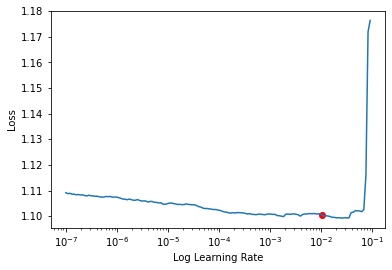

0.010197997569961401

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
lrfinder = LRFinder(model, optimizer, criterion, device=device)
lrfinder.run(train_loader, init_value=1e-7, final_value=1, beta=0.01)
best_lr = lrfinder.plot()
lrfinder.reset()
best_lr

In [20]:
NUM_EPOCHS = 20
# update the optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=6e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

writer = tb.SummaryWriter(f"../../runs/transformer {now}")
train_model(model, criterion, optimizer, writer=writer, scheduler=scheduler,
            train_loader=train_loader, test_loader=test_loader, 
            num_epochs=NUM_EPOCHS, max_norm=5, device=device)

  0%|          | 0/60500 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

### Evaluate Transformer

In [22]:
test_accuracy(model, test_loader, device)

Test size: 9353
Baseline accuracy: 39.39 %
Accuracy: 80.66 %


In [23]:
# save model state
save_model(model, f'../../models/transformer {now}.pth')

In [25]:
# load model state
model = TransformerModel(vocab_size, embedding_size, hidden_size, hidden_size2, hidden_size3, output_size)
load_model(model, f'../../models/transformer {now}.pth', device)
test_accuracy(model, test_loader, device)

TransformerModel(
  (embedding): Embedding(14443, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=

In [26]:
def predict_str(model, sentence):
    model.eval()
    with torch.no_grad():
        tokens = feature_pipeline(sentence, vocab)
        tokens = tokens.to(device=device)
        preds = model(tokens.unsqueeze(0))
        probs = torch.nn.functional.softmax(preds, dim=1)
        yhat = probs.argmax(dim=1)
        return ID_TO_SENTIMENT[yhat.item()]
    

pos = predict_str(model, "Inflation stable as the stock bull market continues")
neu = predict_str(model, "Stock market finished side-ways for the day as GDP reports are released")
neg = predict_str(model, "Inflation on all time high as the stocks keep crashing")
print(f"Positive: {pos}\nNeutral: {neu}\nNegative: {neg}")

Positive: Positive
Neutral: Neutral
Negative: Neutral


In [ ]:
import pickle
# save vocab
with open(f'../../models/vocab {now}.pkl', 'wb') as f:
    pickle.dump(vocab, f)